In [33]:
import sys
sys.path.append('/home/fjargsto/Desktop/BEM Kirkup/Python')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from InteriorHelmholtzSolver2D import *
from InteriorHelmholtzSolver2D_C import *

class RectangleHelmholtzProblem(object):
    def __init__(self, width = 1, height = 1, elements_x = 32, elements_y = 32):
        nElements = 2 * (elements_x + elements_y)
        # key simulation parameters
        self.density   = 1.205 # density of air [kg/m^3]
        self.velocity  = 344.0 # speed of sound in air [m/s]
        self.frequency = 1000  # 1000 Hz 

        # key boundary parameters
        self.width  = width
        self.height = height
        self.elements_x = elements_x
        self.elements_y = elements_y
        
        # implementation specific parameters
        self.bUseOptimized = True

        # creation of boundary discretization
        self.aVertex, self.aEdge = self.Rectangle(width, height, elements_x, elements_y)
        self.boundaryCondition = BoundaryCondition(nElements)
        self.boundaryCondition.alpha.fill(1.0j)
        self.boundaryCondition.beta.fill(1.0)
        self.boundaryCondition.f.fill(0.5)
        self.boundaryCondition.f[0:elements_x+elements_y].fill(1.0)
        # self.boundaryCondition.f[ 0] = 1.0
        # self.boundaryCondition.f[-1] = 1.0
        
        # definition of incident fields on boundary
        self.boundaryIncidence = BoundaryIncidence(nElements)
        self.boundaryIncidence.phi.fill(0.0) # no incoming velocity potential on boundary                                              
        self.boundaryIncidence.v.fill(0.0)   # no incoming velocity on boundary                                                        

        # description of the interior field solution being sought
        self.aInteriorPoints = self.RegularGrid2D(0.0, self.width, 0.0, self.height, 
                                                  self.elements_x, self.elements_y)
        self.aInteriorIncidentPhi = np.zeros(self.aInteriorPoints.shape[0])
        
    # Number of discrete boundary elements
    def numberOfBoundaryElements(self):
        return self.aEdges.shape[1]
    
    # Solve problem as described by object state
    def solve(self):
        if self.bUseOptimized:
            self.squareProblem = InteriorHelmholtzSolver2D_C(self.aVertex, self.aEdge, 
                                                             self.velocity, self.density)
        else:
            self.squareProblem = InteriorHelmholtzSolver2D(self.aVertex, self.aEdge, 
                                                           self.velocity, self.density)
        k = self.squareProblem.frequencyToWavenumber(self.frequency)
        self.boundarySolution = self.squareProblem.solveBoundary(k, self.boundaryCondition,
                                                                 self.boundaryIncidence)
        self.interiorPhi = self.squareProblem.solveInterior(self.boundarySolution, 
                                                            self.aInteriorIncidentPhi, 
                                                            self.aInteriorPoints)

    def showPressureMap(self, t = 0.0):
        pressure = self.squareProblem.soundPressure(self.boundarySolution.k, self.interiorPhi, t)
        pressure = np.reshape(pressure, (self.elements_x, self.elements_y))

        fig = plt.figure()

[ 1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j
  1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j
  1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j
  1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j
  1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j
  1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j
  1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j
  1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j   1.+0.j
  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j
  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j
  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j
  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j
  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j
  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+0.5j  0.+

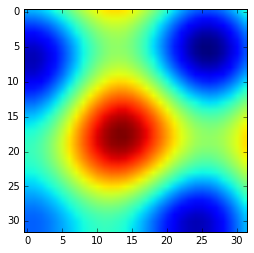

In [41]:
import sys
sys.path.append('/home/fjargsto/Desktop/BEM Kirkup/Python')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from InteriorHelmholtzSolver2D import *
from InteriorHelmholtzSolver2D_C import *

class RectangleHelmholtzProblem(object):
    def __init__(self, width = 1, height = 1, elements_x = 32, elements_y = 32):
        nElements = 2 * (elements_x + elements_y)
        # key simulation parameters
        self.density   = 1.205 # density of air [kg/m^3]
        self.velocity  = 344.0 # speed of sound in air [m/s]
        self.frequency = 1000  # 1000 Hz 

        # key boundary parameters
        self.width  = width
        self.height = height
        self.elements_x = elements_x
        self.elements_y = elements_y
        
        # implementation specific parameters
        self.bUseOptimized = True

        # creation of boundary discretization
        self.aVertex, self.aEdge = self.Rectangle(width, height, elements_x, elements_y)
        self.boundaryCondition = BoundaryCondition(nElements)
        self.boundaryCondition.alpha.fill(1.0)
        self.boundaryCondition.beta.fill(1.0)
        self.boundaryCondition.f.fill(0.5j)
        self.boundaryCondition.f[0:elements_x+elements_y].fill(1.0)
        # self.boundaryCondition.f[ 0] = 1.0
        # self.boundaryCondition.f[-1] = 1.0
        
        # definition of incident fields on boundary
        self.boundaryIncidence = BoundaryIncidence(nElements)
        self.boundaryIncidence.phi.fill(0.0) # no incoming velocity potential on boundary                                              
        self.boundaryIncidence.v.fill(0.0)   # no incoming velocity on boundary                                                        

        # description of the interior field solution being sought
        self.aInteriorPoints = self.RegularGrid2D(0.0, self.width, 0.0, self.height, 
                                                  self.elements_x, self.elements_y)
        self.aInteriorIncidentPhi = np.zeros(self.aInteriorPoints.shape[0])
        
    # Number of discrete boundary elements
    def numberOfBoundaryElements(self):
        return self.aEdges.shape[1]
    
    # Solve problem as described by object state
    def solve(self):
        if self.bUseOptimized:
            self.squareProblem = InteriorHelmholtzSolver2D_C(self.aVertex, self.aEdge, 
                                                             self.velocity, self.density)
        else:
            self.squareProblem = InteriorHelmholtzSolver2D(self.aVertex, self.aEdge, 
                                                           self.velocity, self.density)
        k = self.squareProblem.frequencyToWavenumber(self.frequency)
        self.boundarySolution = self.squareProblem.solveBoundary(k, self.boundaryCondition,
                                                                 self.boundaryIncidence)
        self.interiorPhi = self.squareProblem.solveInterior(self.boundarySolution, 
                                                            self.aInteriorIncidentPhi, 
                                                            self.aInteriorPoints)

    def showPressureMap(self, t = 0.0):
        pressure = self.squareProblem.soundPressure(self.boundarySolution.k, self.interiorPhi, t)
        pressure = np.reshape(pressure, (self.elements_x, self.elements_y))

        fig = plt.figure()
        im = plt.imshow(pressure.imag)
        plt.show()
        
    def showPressureAnimation(self):
        T = 1.0 / self.frequency
        nFrames = 120
        deltaT = T / nFrames
        t = 0.0
        pressure = self.squareProblem.soundPressure(self.boundarySolution.k, self.interiorPhi, t)
        pressure = np.reshape(pressure, (self.elements_x, self.elements_y))

        fig = plt.figure()
        im = plt.imshow(pressure.imag, animated=True)

        def update(frame):
            t = frame * deltaT
            pressure = self.squareProblem.soundPressure(self.boundarySolution.k, self.interiorPhi, t)
            pressure = np.reshape(pressure, (self.elements_x, self.elements_y))
            im.set_array(pressure.imag)
            return im,

        ani = FuncAnimation(fig, update, nFrames, interval=25, blit=True)        
        plt.show()
        return ani

    @classmethod
    def Rectangle(cls, width, height, elements_x, elements_y):
        nBoudnaryElements = 2 * (elements_x + elements_y)
        # boundary elements are edges
        aEdge = np.empty((nBoudnaryElements, 2), dtype=np.int32)
        aEdge[:,  0] = range(nBoudnaryElements)
        aEdge[:-1,  1] = range(1, nBoudnaryElements)
        aEdge[-1, 1] = 0
        
        aVertex = np.empty((nBoudnaryElements, 2), dtype=np.float32)
        # up the y-Axis
        aVertex[0:elements_y, 0] = 0.0
        aVertex[0:elements_y, 1] = np.linspace(0.0, height, elements_y, False)
        # over to the right along top edge
        aVertex[elements_y:elements_y+elements_x, 0] = np.linspace(0.0, width, elements_x, False)
        aVertex[elements_y:elements_y+elements_x, 1] = height
        # back down to x-axis
        aVertex[elements_y+elements_x:2*elements_y + elements_x, 0] = width
        aVertex[elements_y+elements_x:2*elements_y + elements_x, 1] = np.linspace(height, 
                                                                                  0.0, 
                                                                                  elements_y, 
                                                                                  False)
        # going left back to origin
        aVertex[2*elements_y + elements_x:2 * (elements_y+elements_x), 0] = np.linspace(width, 
                                                                                        0.0, 
                                                                                        elements_x, 
                                                                                        False)
        aVertex[2*elements_y + elements_x:2 * (elements_y+elements_x), 1] = 0.0

        return aVertex, aEdge
    
    @classmethod
    def RegularGrid2D(cls, left = 0.0, right = 1.0, bottom = 0.0, top = 1.0, 
                      elements_x = 32, elements_y = 32):
        nPoints = elements_x * elements_y
        
        aGridPoints = np.empty((nPoints, 2), dtype=np.float32)
        temp = np.reshape(aGridPoints, (elements_x, elements_y, 2))
        delta_x = (right - left) / elements_x
        delta_y = (top - bottom) / elements_y
        for i in range(elements_x):
            for j in range(elements_y):
                temp[i, j,:] = [(i + 0.5) * delta_x, (j + 0.5) * delta_y]
   
        return aGridPoints
      
r = RectangleHelmholtzProblem(1.2, 1.2, 32, 32)
r.frequency = 367
print r.boundaryCondition.f
r.solve()
r.showPressureMap()
#ani = r.showPressureAnimation()
#HTML(ani.to_html5_video())

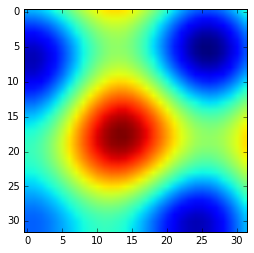

In [42]:
ani = r.showPressureAnimation()
HTML(ani.to_html5_video())

16


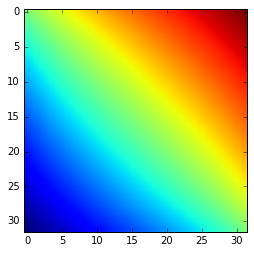

32


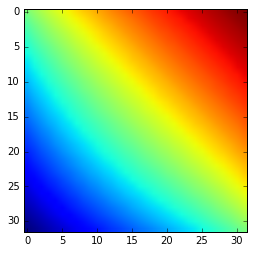

64


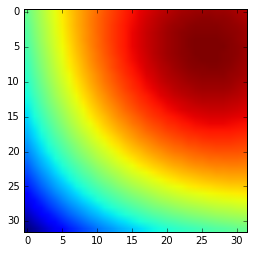

128


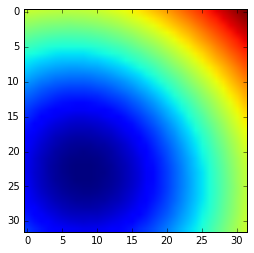

256


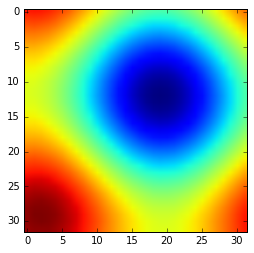

512


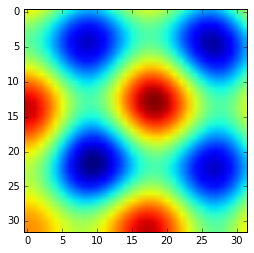

1024


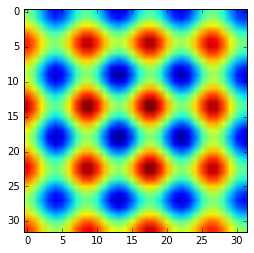

2048


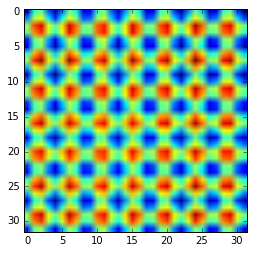

4096


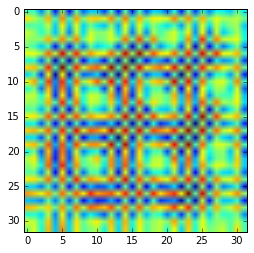

8192


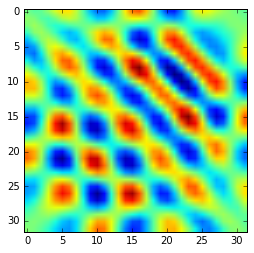

16384


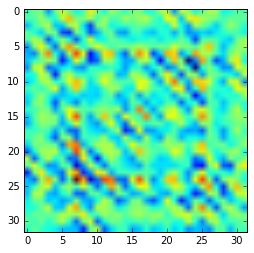

In [36]:
f = 16
for i in range(11):
    r.frequency = f * 2**i
    print r.frequency
    r.solve()
    r.showPressureMap()